In [46]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import re



In [47]:
signatures_folder_path = "signature_matrices_failing_KL"
cosmic_signatures_path = "cosmic_signatures/COSMIC_v3.4_SBS_GRCh37.txt"

signature_sets = {
    8:  ["SBS17b", "SBS86", "SBS98", "SBS39", "SBS22a", "SBS43", "SBS17a", "SBS13"],
    15: ["SBS17b", "SBS86", "SBS98", "SBS39", "SBS22a", "SBS43", "SBS17a", "SBS13", 
         "SBS54", "SBS33", "SBS21", "SBS59", "SBS60", "SBS87", "SBS37"],
    25: ["SBS17b", "SBS86", "SBS98", "SBS39", "SBS22a", "SBS43", "SBS17a", "SBS13", 
         "SBS54", "SBS33", "SBS21", "SBS59", "SBS60", "SBS87", "SBS37", "SBS96", 
         "SBS28", "SBS55", "SBS99", "SBS26", "SBS3", "SBS1", "SBS12", "SBS93", "SBS22b"]
}

In [48]:
scenario = 8  # or 15, 25
signatures_to_extract = signature_sets[scenario]


# LOAD COSMIC DATA

signatures_df = pd.read_csv(cosmic_signatures_path, sep="\t")
if "Type" in signatures_df.columns:
    signatures_df.set_index("Type", inplace=True)

extracted_signatures = signatures_df[signatures_to_extract]
true_signatures = extracted_signatures.to_numpy()
true_sig_names = extracted_signatures.columns

In [49]:
# From sig_profiler_extractor
def evaluation(true_sigs, est_sigs, cutoff=0.2, dist="cos", verbose=False):
    if true_sigs.shape[1] >= est_sigs.shape[1]:
        mat1 = est_sigs
        mat2 = true_sigs
    else:
        mat1 = true_sigs
        mat2 = est_sigs

    if dist == "cos":
        con_mat = cdist(mat1.T, mat2.T, "cosine")
    elif dist == "cor":
        con_mat = cdist(mat1.T, mat2.T, "correlation")

    row_ind, col_ind = linear_sum_assignment(con_mat)
    con_mat = 1 - con_mat  # Convert distance -> similarity

    idxPair = {}
    true_positives = 0
    for x, y in zip(row_ind, col_ind):
        idxPair[x] = y
        if con_mat[x, y] >= cutoff:
            true_positives += 1

    computedFalsePositives = mat1.shape[1] - true_positives
    computedFalseNegatives = computedFalsePositives

    if true_sigs.shape[1] >= est_sigs.shape[1]:
        baseFalsePositives = 0
        baseFalseNegatives = true_sigs.shape[1] - est_sigs.shape[1]
    else:
        baseFalsePositives = est_sigs.shape[1] - true_sigs.shape[1]
        baseFalseNegatives = 0

    false_positives = baseFalsePositives + computedFalsePositives
    false_negatives = baseFalseNegatives + computedFalseNegatives
    number_of_ground_truth_signatures = true_sigs.shape[1]
    number_of_detected_signature = est_sigs.shape[1]

    try:
        precision = round(true_positives / (true_positives + false_positives), 2)
        recall = round(true_positives / (true_positives + false_negatives), 2)
        f1_score = round(2 * precision * recall / (precision + recall), 2)
    except ZeroDivisionError:
        precision = 0
        recall = 0
        f1_score = 0

    return (
        number_of_ground_truth_signatures,
        number_of_detected_signature,
        true_positives,
        false_positives,
        false_negatives,
        precision,
        recall,
        f1_score,
        idxPair,
    )

With a cutoff of 0.9
Evaluating learned_dictionary_D_run64.csv
Evaluating learned_dictionary_D_run70.csv
Evaluating learned_dictionary_D_run58.csv
Evaluating learned_dictionary_D_run1.csv
Evaluating learned_dictionary_D_run59.csv
Evaluating learned_dictionary_D_run71.csv
Evaluating learned_dictionary_D_run65.csv
Evaluating learned_dictionary_D_run73.csv
Evaluating learned_dictionary_D_run67.csv
Evaluating learned_dictionary_D_run98.csv
Evaluating learned_dictionary_D_run3.csv
Evaluating learned_dictionary_D_run2.csv
Evaluating learned_dictionary_D_run99.csv
Evaluating learned_dictionary_D_run66.csv
Evaluating learned_dictionary_D_run72.csv
Evaluating learned_dictionary_D_run76.csv
Evaluating learned_dictionary_D_run62.csv
Evaluating learned_dictionary_D_run89.csv
Evaluating learned_dictionary_D_run6.csv
Evaluating learned_dictionary_D_run7.csv
Evaluating learned_dictionary_D_run88.csv
Evaluating learned_dictionary_D_run63.csv
Evaluating learned_dictionary_D_run77.csv
Evaluating learned

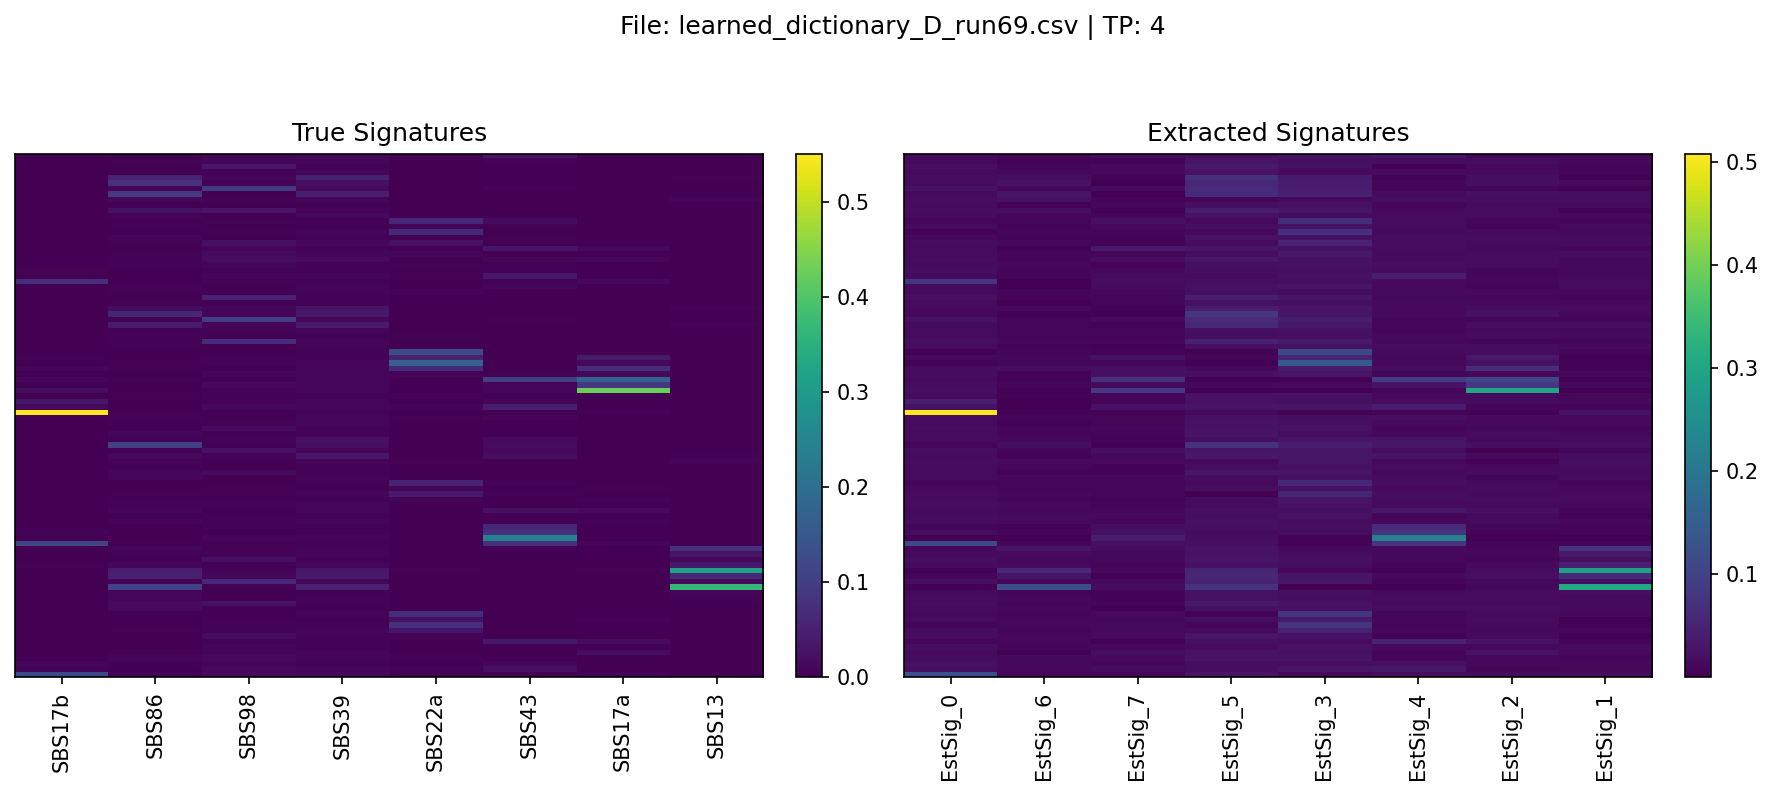

--------------------------------------------------


In [50]:
# Same setup as before: loading CSV files, evaluating with the evaluation() function,
# and having true_signatures, true_sig_names, etc. already defined.

csv_files = glob.glob(os.path.join(signatures_folder_path, "*.csv"))
cutoff = 0.9
print("With a cutoff of", cutoff)
number_of_tp = 0
number_of_files = 0
for csv_file in csv_files:
    number_of_files +=1
    print(f"Evaluating {os.path.basename(csv_file)}")
    nmf_signatures_df = pd.read_csv(csv_file, header=None)
    nmf_signatures = nmf_signatures_df.to_numpy()

    (
        gt_count, det_count, tp, fp, fn,
        prec, rec, f1, idx_pair
    ) = evaluation(true_signatures, nmf_signatures, cutoff=cutoff, dist="cos")
    number_of_tp += tp
    #print(f"  True Positives: {tp}")
print('pourcentage of tp ',number_of_tp/number_of_files/8)
    # -----------------------------
    # LEFT (Ground Truth)
    # -----------------------------
left_matrix = true_signatures
left_names = true_sig_names

    # -----------------------------
    # RIGHT (Estimated, Reordered)
    # -----------------------------
right_matrix = np.zeros_like(left_matrix)
right_names = ["NoMatch"] * left_matrix.shape[1]

for est_col, true_col in idx_pair.items():
    right_matrix[:, true_col] = nmf_signatures[:, est_col]
    right_names[true_col] = f"EstSig_{est_col}"

    # -----------------------------
    # PLOT WITH MATPLOTLIB
    # -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

    # 1) LEFT HEATMAP
im_left = axes[0].imshow(left_matrix, aspect="auto", cmap="viridis")
axes[0].set_title("True Signatures")
    # X-axis labels
axes[0].set_xticks(range(left_matrix.shape[1]))
axes[0].set_xticklabels(left_names, rotation=90)
    # Hide Y-axis labels if not meaningful
axes[0].set_yticks([])
    # Add colorbar
fig.colorbar(im_left, ax=axes[0], fraction=0.046, pad=0.04)

    # 2) RIGHT HEATMAP
im_right = axes[1].imshow(right_matrix, aspect="auto", cmap="viridis")
axes[1].set_title("Extracted Signatures")
axes[1].set_xticks(range(right_matrix.shape[1]))
axes[1].set_xticklabels(right_names, rotation=90)
axes[1].set_yticks([])
fig.colorbar(im_right, ax=axes[1], fraction=0.046, pad=0.04)

fig.suptitle(f"File: {os.path.basename(csv_file)} | TP: {tp}", y=1.05)

plt.tight_layout()
plt.show()
print("-" * 50)


In [51]:
import os
!pip install pyclustering

import numpy as np
import pyclustering
import pandas as pd
from scipy.spatial.distance import cdist
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric
import random

def pam_cosine_clustering(
    signatures_folder,
    n_clusters=8,
    output_csv="retrieved_KL_signatures_pam.csv",
    random_seed=42
):
    """
    Reads all CSV files from `signatures_folder`, performs PAM clustering
    using cosine distance, and saves the cluster medoids to `output_csv`.
    Returns: all_signatures, clusters, final_medoids
    """
    random.seed(random_seed)  # for reproducibility
    
    # ------------------------------------------------------------
    # Step A: Collect signature columns from each CSV file
    # ------------------------------------------------------------
    csv_files = [
        f for f in os.listdir(signatures_folder) 
        if f.endswith(".csv")
    ]
    
    all_signatures_list = []
    
    for file_name in csv_files:
        file_path = os.path.join(signatures_folder, file_name)
        
        # Read the CSV (no header)
        D_matrix = pd.read_csv(file_path, header=None).values  # shape: (num_bins, k)
        
        # Each column is one signature vector
        for col_idx in range(D_matrix.shape[1]):
            signature_vector = D_matrix[:, col_idx]  # shape: (num_bins,)
            all_signatures_list.append(signature_vector)
    
    # Convert to a single NumPy array: (total_signatures, num_bins)
    all_signatures = np.array(all_signatures_list)
    num_signatures, num_bins = all_signatures.shape
    
    print(f"Loaded {num_signatures} total signatures from folder '{signatures_folder}'.")
    print(f"all_signatures shape: {all_signatures.shape}")
    
    # ------------------------------------------------------------
    # Step B: Define a custom distance function using cosine
    # ------------------------------------------------------------
    def custom_cosine_distance(vec_a, vec_b):
        # vec_a, vec_b: 1D arrays
        return cdist([vec_a], [vec_b], "cosine")[0, 0]
    
    metric = distance_metric(type_metric.USER_DEFINED, func=custom_cosine_distance)
    
    # ------------------------------------------------------------
    # Step C: Initialize and run k-medoids (PAM) with random medoids
    # ------------------------------------------------------------
    if n_clusters > num_signatures:
        raise ValueError(
            f"n_clusters ({n_clusters}) is greater than total signatures ({num_signatures})."
        )
    
    # Pick random distinct indices as initial medoids
    initial_medoids = random.sample(range(num_signatures), n_clusters)
    
    # k-medoids requires a list of lists
    all_signatures_list_of_lists = [sig.tolist() for sig in all_signatures]
    
    kmedoids_instance = kmedoids(
        data=all_signatures_list_of_lists,
        initial_index_medoids=initial_medoids,
        metric=metric
    )
    kmedoids_instance.process()
    
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    
    print(f"\n=== Clustering Results ===")
    print(f"Number of clusters found: {len(clusters)}")
    for i, cluster_indices in enumerate(clusters, start=1):
        print(f"  Cluster {i}: {len(cluster_indices)} signature(s)")
    print(f"Medoid indices: {final_medoids}")
    
    # ------------------------------------------------------------
    # Step D: Retrieve the actual medoid signatures
    # ------------------------------------------------------------
    medoid_signatures = [all_signatures[idx] for idx in final_medoids]
    
    # Convert to DataFrame and save
    df_medoids = pd.DataFrame(medoid_signatures).T
    df_medoids.to_csv(output_csv, index=False, header=False)
    print(f"\nSaved medoids to '{output_csv}'.")
    
    # ------------------------------------------------------------
    # Return values for further use
    # ------------------------------------------------------------
    return all_signatures, clusters, final_medoids



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [52]:
# if __name__ == "__main__":
#     signatures_folder_path = "signature_matrices_passing_KL"
    
#     pam_cosine_clustering(
#         signatures_folder=signatures_folder_path,
#         n_clusters=8,
#         output_csv="cluster_matrix/retrieved_signatures_pam.csv",
#         random_seed=42
#     )


In [53]:
if __name__ == "__main__":
    signatures_folder_path = "signature_matrices_failing_KL"
    
    all_signatures, clusters, final_medoids = pam_cosine_clustering(
        signatures_folder=signatures_folder_path,
        n_clusters=8,
        output_csv="cluster_matrix/retrieved_signatures_pam.csv",
        random_seed=42
    )


Loaded 800 total signatures from folder 'signature_matrices_failing_KL'.
all_signatures shape: (800, 96)

=== Clustering Results ===
Number of clusters found: 8
  Cluster 1: 56 signature(s)
  Cluster 2: 123 signature(s)
  Cluster 3: 51 signature(s)
  Cluster 4: 74 signature(s)
  Cluster 5: 154 signature(s)
  Cluster 6: 103 signature(s)
  Cluster 7: 155 signature(s)
  Cluster 8: 84 signature(s)
Medoid indices: [450, 282, 259, 498, 696, 578, 520, 571]


OSError: Cannot save file into a non-existent directory: 'cluster_matrix'

Cluster plot with true signatures saved to 'clusters_with_true_signatures.png'


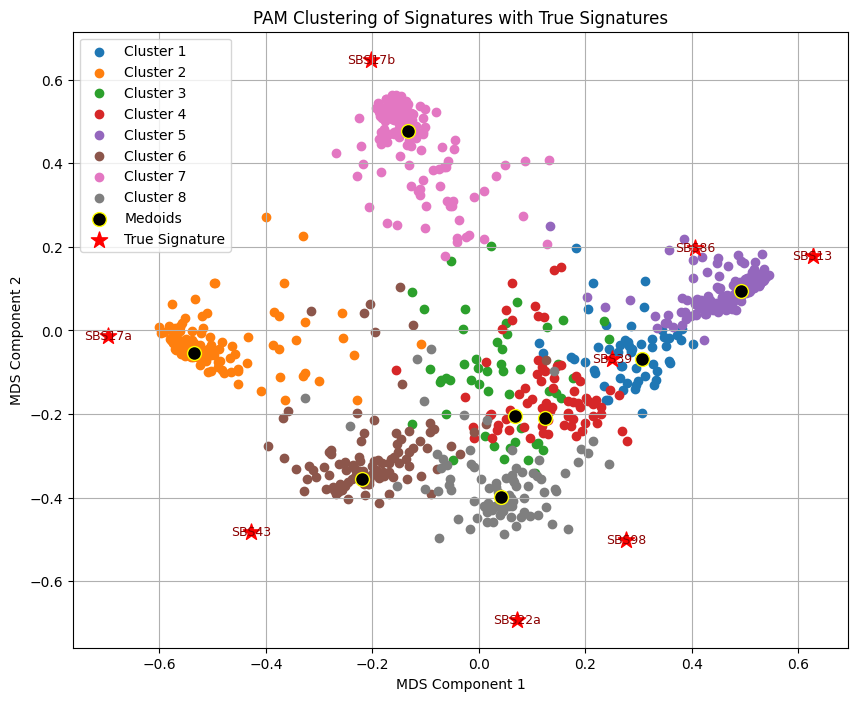

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def plot_clusters_with_true_signatures(
    all_signatures, clusters, medoids, true_signatures, true_sig_names, output_plot="clusters_with_true_signatures.png"
):
    """
    Visualizes clusters with true signatures using MDS for dimensionality reduction.
    """
    # Transpose true_signatures to align dimensions
    true_signatures = true_signatures.T

    # Combine all signatures and true signatures for visualization
    combined_signatures = np.vstack([all_signatures, true_signatures])
    combined_labels = ["Clustered"] * len(all_signatures) + list(true_sig_names)

    # Reduce to 2D using MDS with cosine distance
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    distance_matrix = cdist(combined_signatures, combined_signatures, metric="cosine")
    reduced_data = mds.fit_transform(distance_matrix)

    # Separate reduced data
    reduced_all_signatures = reduced_data[:len(all_signatures)]
    reduced_true_signatures = reduced_data[len(all_signatures):]

    plt.figure(figsize=(10, 8))

    # Plot each cluster
    for cluster_idx, cluster_indices in enumerate(clusters):
        cluster_data = reduced_all_signatures[cluster_indices]
        plt.scatter(
            cluster_data[:, 0], cluster_data[:, 1],
            label=f"Cluster {cluster_idx + 1}"
        )

    # Highlight medoids
    medoid_data = reduced_all_signatures[medoids]
    plt.scatter(
        medoid_data[:, 0], medoid_data[:, 1],
        color="black", s=100, label="Medoids", edgecolor="yellow", zorder=5
    )

    # Add true signatures
    for i, (x, y) in enumerate(reduced_true_signatures):
        plt.scatter(x, y, color="red", marker="*", s=150, label="True Signature" if i == 0 else None)
        plt.text(x, y, true_sig_names[i], fontsize=9, ha="center", va="center", color="darkred")

    # Add labels and legend
    plt.title("PAM Clustering of Signatures with True Signatures")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.legend()
    plt.grid(True)

    # Save and show plot
    plt.savefig(output_plot)
    print(f"Cluster plot with true signatures saved to '{output_plot}'")
    plt.show()

# Usage:
plot_clusters_with_true_signatures(
    all_signatures=all_signatures,
    clusters=clusters,
    medoids=final_medoids,
    true_signatures=true_signatures,
    true_sig_names=true_sig_names
)


In [ ]:
print(f"all_signatures shape: {all_signatures.shape}")
print(f"true_signatures shape: {true_signatures.shape}")


all_signatures shape: (800, 96)
true_signatures shape: (96, 8)
